In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from helpers.plot_helpers import *
from helpers.computational_tools import gaussian_remesh
%load_ext autoreload
%autoreload 3
import warnings
warnings.filterwarnings("ignore")

In [3]:
from helpers.collection_of_experiments import *

In [5]:
ds = CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Feb2022/bare', additional_subfolder='output')
ds += CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Apr2023/generalization', additional_subfolder='output')

In [6]:
ds += CollectionOfExperiments.init_folder('/vast/pp2681/Yellowstone/generalization-FGR-sqrt12', additional_subfolder='output', prefix='FGR-sqrt12')

In [7]:
ds += CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Wenda-WENO', additional_subfolder='output')

In [66]:
ds += CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/CM26_Double_Gyre/generalization', additional_subfolder='output')

In [12]:
for RR in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']:
    ds.remesh('R64', RR)

Experiment R64 coarsegrained to R2 is created. Its identificator=R64_R2
Experiment R64 coarsegrained to R3 is created. Its identificator=R64_R3
Experiment R64 coarsegrained to R4 is created. Its identificator=R64_R4
Experiment R64 coarsegrained to R5 is created. Its identificator=R64_R5
Experiment R64 coarsegrained to R6 is created. Its identificator=R64_R6
Experiment R64 coarsegrained to R7 is created. Its identificator=R64_R7
Experiment R64 coarsegrained to R8 is created. Its identificator=R64_R8


In [13]:
for RR in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']:
    ds.remesh('R64', RR, operator=gaussian_remesh, FGR=np.sqrt(12), exp=f'R64_{RR}_FGR-sqrt12')

for RR in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']:
    for file in [f'/scratch/pp2681/Yellowstone/filtered-data/R64_{RR}_FGR-sqrt12-part1.nc', 
                 f'/scratch/pp2681/Yellowstone/filtered-data/R64_{RR}_FGR-sqrt12-part2.nc',
                 f'/scratch/pp2681/Yellowstone/filtered-data/R64_{RR}_FGR-sqrt12-part3.nc']:
            dataset = xr.open_dataset(file, decode_times=False)
            for key in dataset.keys():
                var = dataset[key]
                #var['Time'] = ds['R64'].u['Time']
                setattr(ds[f'R64_{RR}_FGR-sqrt12'], key, var)

Experiment R64 coarsegrained to R2 is created. Its identificator=R64_R2_FGR-sqrt12
Experiment R64 coarsegrained to R3 is created. Its identificator=R64_R3_FGR-sqrt12
Experiment R64 coarsegrained to R4 is created. Its identificator=R64_R4_FGR-sqrt12
Experiment R64 coarsegrained to R5 is created. Its identificator=R64_R5_FGR-sqrt12
Experiment R64 coarsegrained to R6 is created. Its identificator=R64_R6_FGR-sqrt12
Experiment R64 coarsegrained to R7 is created. Its identificator=R64_R7_FGR-sqrt12
Experiment R64 coarsegrained to R8 is created. Its identificator=R64_R8_FGR-sqrt12


# Compute metrics

In [14]:
def sample_ssh(exp, target):
    sample = []
    for year_start in [5, 10, 15]:
        try:
            year_end = year_start + 5
            idx = slice(365*year_start, 365*year_end)
            sample.append(
                Lk_error(ds[exp].ea.isel(zi=0).sel(Time=idx).mean('Time'), ds[target].ssh_mean)[0]
            )
        except:
            sample.append(np.nan)
    return xr.DataArray(sample, dims='sample')

In [15]:
def sample_KE(exp, target=None):
    sample = []
    for year_start in [5, 10, 15]:
        try:
            year_end = year_start + 5
            idx = slice(365*year_start, 365*year_end)
            u = ds[exp].u.sel(Time=idx)
            v = ds[exp].v.sel(Time=idx)
            h = ds[exp].h.sel(Time=idx)
    
            KE = 1e-15 * ds[exp].KE_joul(u, v, h).mean('Time').sum()
            sample.append(KE)
        except:
            sample.append(np.nan)
    return xr.DataArray(sample, dims='sample')

In [16]:
def sample_APE(exp, target=None):
    sample = []
    for year_start in [5, 10, 15]:
        try:
            year_end = year_start + 5
            idx = slice(365*year_start, 365*year_end)
            e = ds[exp].e.sel(Time=idx)
            APE = 1e-15 * (
                ds[exp].PE_joul(e).mean('Time').sum() + 
                ds[exp].PE_ssh(e).mean('Time').sum()
            )
            sample.append(APE)
        except:
            sample.append(np.nan)
    return xr.DataArray(sample, dims='sample')

In [17]:
#error = xr.open_dataset('generalization-FGR-sqrt12.nc').load()

In [28]:
%%time 
for key in ['WENO7', 'WENO7V']:
    for fun, fun_str in zip([sample_APE, sample_KE, sample_ssh], ['APE', 'KE', 'ssh']):
        %time error[f'{key}-{fun_str}'] = xr.concat([fun(f'{key}-{conf}',f'R64_{conf}_FGR-sqrt12') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')


CPU times: user 7.57 s, sys: 862 ms, total: 8.44 s
Wall time: 8.61 s

CPU times: user 18.4 s, sys: 1.05 s, total: 19.4 s
Wall time: 12.1 s

CPU times: user 3.13 s, sys: 502 ms, total: 3.63 s
Wall time: 4.41 s

CPU times: user 7.41 s, sys: 733 ms, total: 8.15 s
Wall time: 7.96 s

CPU times: user 16 s, sys: 888 ms, total: 16.9 s
Wall time: 11.1 s

CPU times: user 2.95 s, sys: 552 ms, total: 3.5 s
Wall time: 4.12 s
CPU times: user 55.5 s, sys: 4.58 s, total: 1min
Wall time: 48.3 s


In [ ]:
%%time 
for key in ['WENO7', 'WENO7V']:
    for fun, fun_str in zip([sample_APE, sample_KE, sample_ssh], ['APE', 'KE', 'ssh']):
        %time error[f'{key}-{fun_str}'] = xr.concat([fun(f'{key}-{conf}',f'R64_{conf}_FGR-sqrt12') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')

In [67]:
%%time 
for key in ['Jansen-Held']:
    for fun, fun_str in zip([sample_APE, sample_KE, sample_ssh], ['APE', 'KE', 'ssh']):
        %time error[f'{key}-{fun_str}'] = xr.concat([fun(f'{key}-{conf}-ref',f'R64_{conf}_FGR-sqrt12') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')

CPU times: user 5.65 s, sys: 439 ms, total: 6.09 s
Wall time: 6.95 s
CPU times: user 15.9 s, sys: 802 ms, total: 16.7 s
Wall time: 11.1 s
CPU times: user 1.4 s, sys: 209 ms, total: 1.61 s
Wall time: 1.55 s
CPU times: user 22.9 s, sys: 1.45 s, total: 24.4 s
Wall time: 19.6 s


In [68]:
%%time 
for key in ['Yankovsky24']:
    for fun, fun_str in zip([sample_APE, sample_KE, sample_ssh], ['APE', 'KE', 'ssh']):
        %time error[f'{key}-{fun_str}'] = xr.concat([fun(f'{key}-{conf}-ref',f'R64_{conf}_FGR-sqrt12') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')

CPU times: user 5.54 s, sys: 405 ms, total: 5.95 s
Wall time: 5.6 s
CPU times: user 14.9 s, sys: 855 ms, total: 15.8 s
Wall time: 10.6 s
CPU times: user 1.29 s, sys: 182 ms, total: 1.48 s
Wall time: 1.21 s
CPU times: user 21.8 s, sys: 1.44 s, total: 23.2 s
Wall time: 17.4 s


In [72]:
%%time 
key = 'May22-FGR3-subfilter-EXP1'
for fun, fun_str in zip([sample_APE, sample_KE, sample_ssh], ['APE', 'KE', 'ssh']):
    %time error[f'ANN-{fun_str}'] = xr.concat([fun(f'{key}-{conf}-ZB-1.0-Cs-0.06',f'R64_{conf}_FGR-sqrt12') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')

CPU times: user 8.3 s, sys: 846 ms, total: 9.15 s
Wall time: 9.21 s
CPU times: user 15.3 s, sys: 937 ms, total: 16.2 s
Wall time: 10.5 s
CPU times: user 2.75 s, sys: 501 ms, total: 3.25 s
Wall time: 3.76 s
CPU times: user 26.3 s, sys: 2.28 s, total: 28.6 s
Wall time: 23.5 s


In [73]:
#error.to_netcdf('generalization-Wenda-WENO.nc')

# Plot metrics

In [84]:
error = xr.open_dataset('generalization-Wenda-WENO.nc').load()

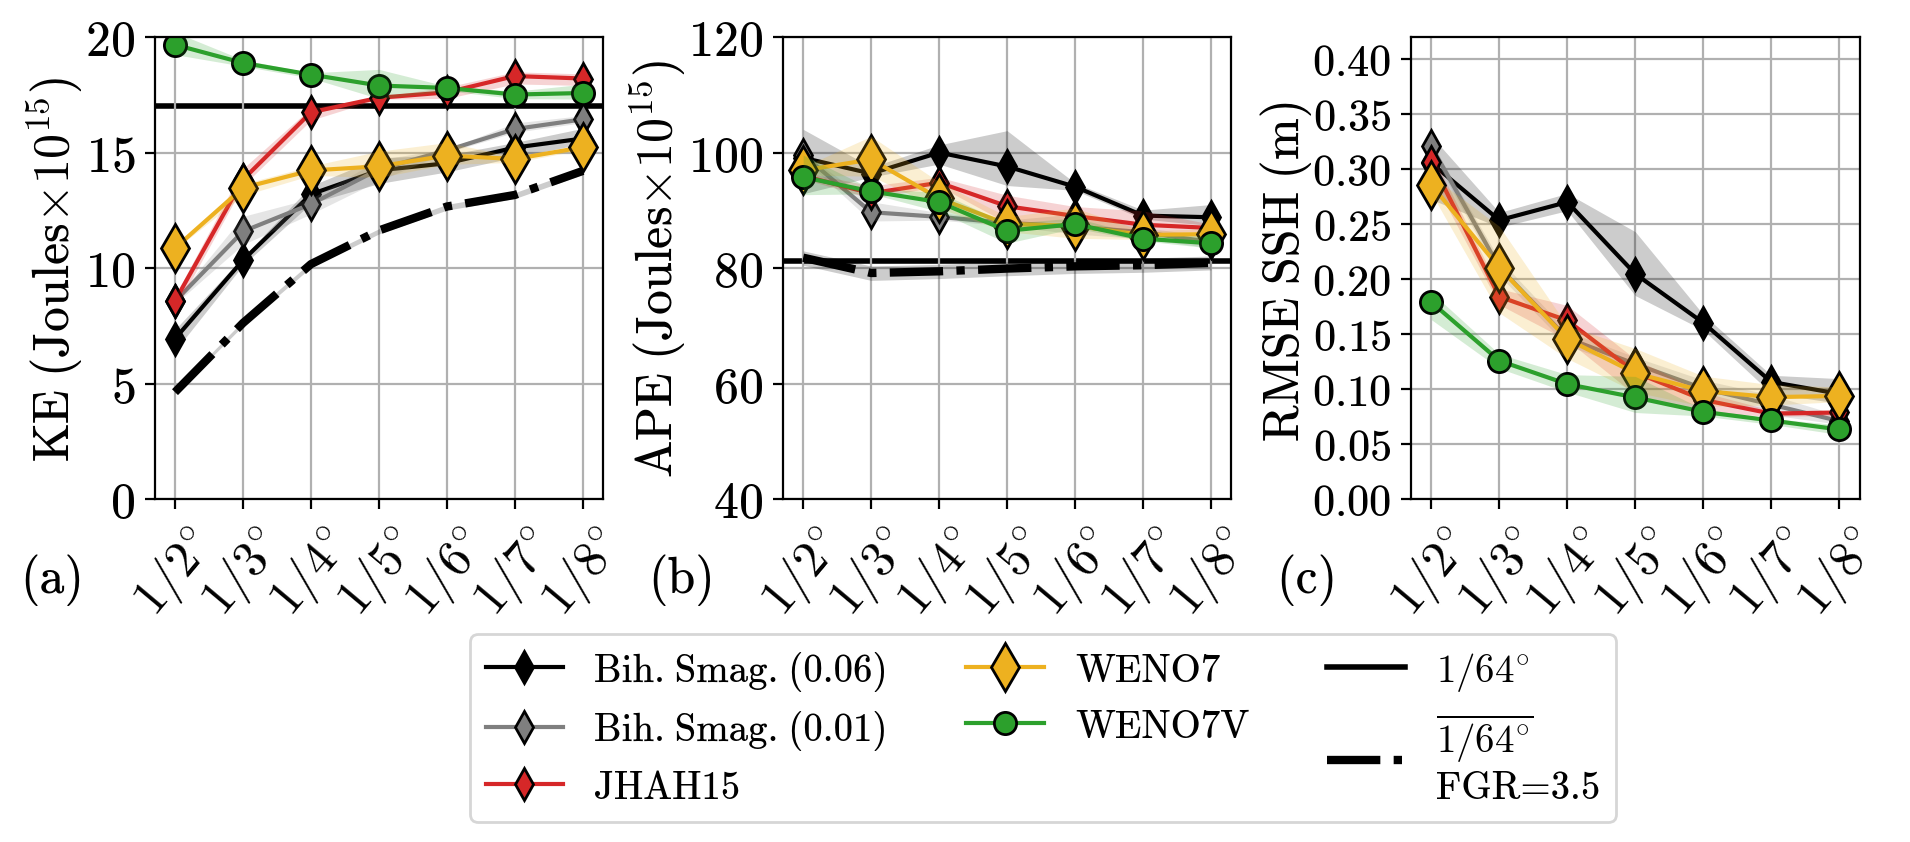

In [81]:
default_rcParams({'font.size': 18, 'figure.subplot.wspace': 0.4, 'figure.subplot.hspace': 0.1})
plt.figure(figsize=(11,3), dpi=200)

yellow = [0.9290, 0.6940, 0.1250]
violet = [0.4940, 0.1840, 0.5560]
lightblue = [0.3010, 0.7450, 0.9330]

for row, fun_str in enumerate(['KE', 'APE', 'ssh']):
    plt.subplot(1,3,row+1)

    def plot_markers_with_filling(model='Jansen-Held', color='tab:red', marker='s', label=None, markersize=None, lw=None, ls=None, alpha=1, zorder=None):
        try:
            ave = []
            if 'sample' in error[model].dims:
                ave.append('sample')
            if 'zl' in error[model].dims:
                ave.append('zl')
    
            error[model].mean(ave).plot(color=color, marker=marker, label=label, markersize=markersize, markeredgecolor='k', lw=lw, ls=ls, alpha=alpha, zorder=zorder)
            plt.fill_between(range(7), error[model].min(ave), error[model].max(ave), color=color, alpha=0.2, lw=0, zorder=zorder)
        except:
            pass
    
    
    plot_markers_with_filling(f'bare-{fun_str}', 'k', 'd', 'Bih. Smag. (0.06)', 8, zorder=2)
    #plot_markers_with_filling(f'bare-0.03-{fun_str}', 'tab:gray', 'd', 'Bih. Smag. (0.03)', 8, zorder=2)
    plot_markers_with_filling(f'bare-0.01-{fun_str}', 'tab:gray', 'd', 'Bih. Smag. (0.01)', 8, zorder=2)
    plot_markers_with_filling(f'Jansen-Held-{fun_str}', 'tab:red', 'd', 'JHAH15', 8, alpha=1, zorder=2)

    plot_markers_with_filling(f'WENO7-{fun_str}', yellow, 'd', 'WENO7', 12, zorder=2)
    plot_markers_with_filling(f'WENO7V-{fun_str}', 'tab:green', 'o', 'WENO7V', 8, zorder=2)

    
    #plot_markers_with_filling(f'DbMM-R-{fun_str}', 'tab:green', 'o', 'Vorticity closure', 8, alpha=1,zorder=5)
    #plot_markers_with_filling(f'ZB-Smooth-{fun_str}', yellow, 'd', 'Bih. Smag+\nZB20-Smooth', 8, alpha=1,zorder=3)
    #plot_markers_with_filling(f'DbMMh-R-{fun_str}', violet, 'o', 'Vorticity+thickness closure', 8, alpha=1,zorder=4)
    #plot_markers_with_filling(f'GM-125-{fun_str}', 'tab:orange', 'd', 'Bih. Smag+\nGent-McWilliams', 8, alpha=1, zorder=2)
    
    if fun_str in ['KE', 'APE']:
       plot_markers_with_filling(f'R64-FGR-sqrt12-{fun_str}', 'k', '', 'filtered \n$1/64^{\circ}$', ls='-.', lw=3,zorder=6)
    
    plt.xticks([0,1,2,3,4,5,6], ['$1/2^{\circ}$', '$1/3^{\circ}$', '$1/4^{\circ}$', '$1/5^{\circ}$', '$1/6^{\circ}$', '$1/7^{\circ}$', '$1/8^{\circ}$'],rotation=50)    
    plt.grid()
    plt.xlabel('')
    if fun_str == 'KE':
        yticks = np.arange(0,40,5)
        plt.ylabel('KE (Joules$\\times10^{15}$)')
        plt.yticks(yticks)
        plt.ylim([0,20])
        plt.axhline(y=17.04075970194989,color='k', zorder=-1,lw=2)
        #plt.title('Kinetic energy (KE)', fontsize=16)
        #plt.text(0.0, 17.5,'$1/64^{\circ}$', color='gray')
    if fun_str == 'EKE':
        yticks = np.arange(0,40,5)
        plt.ylabel('EKE, Joules$\\times10^{15}$')
        plt.axhline(y=10.91081797,color='gray', zorder=-1,lw=3)
        plt.yticks(yticks)
        plt.ylim([0,20])
    if fun_str == 'MKE':
        yticks = np.arange(0,40,5)
        plt.ylabel('MKE, Joules$\\times10^{15}$')
        plt.axhline(y=6.12994173,color='gray', zorder=-1,lw=3)
        plt.yticks(yticks)
        plt.ylim([0,20])
    if fun_str == 'APE':
        yticks = np.arange(40,130,20)
        plt.ylabel('APE (Joules$\\times10^{15}$)')
        #plt.title('Available \n potential energy (APE)', fontsize=16)
        plt.yticks(yticks)
        plt.ylim([min(yticks), max(yticks)])
        plt.axhline(y=81.31324435644875,color='k',zorder=-1,lw=2)
    
    if fun_str == 'ssh':
        yticks = np.arange(0,0.45,0.05)
        plt.ylabel('RMSE SSH (m)')
        #plt.title('RMSE in time-averaged \nsea surface height (SSH)', fontsize=16)
        plt.yticks(yticks, fontsize=16)
        plt.ylim([0,0.42])

    if fun_str == 'Cs':
        plt.ylim([0,0.1])
        plt.ylabel('$C_S$')

plt.gcf().align_ylabels()
#set_letters(fontsize=18,x=0.0,y=1.05)
plt.plot(np.nan,np.nan,'-',color='k',lw=2,label='$1/64^{\circ}$')
plt.plot(np.nan,np.nan,'-.',color='k',lw=3,label='$\\overline{1/64^{\circ}}$\nFGR=3.5')
#plt.plot(np.nan,np.nan,'--',color='k',lw=3,label='filtered $1/64^{\circ}$')
plt.legend(ncol=3, bbox_to_anchor=(0.5,-0.25), fontsize=14)

set_letters(fontsize=18, x=-0.3,y=-0.2, fontweight='normal')
#plt.tight_layout()

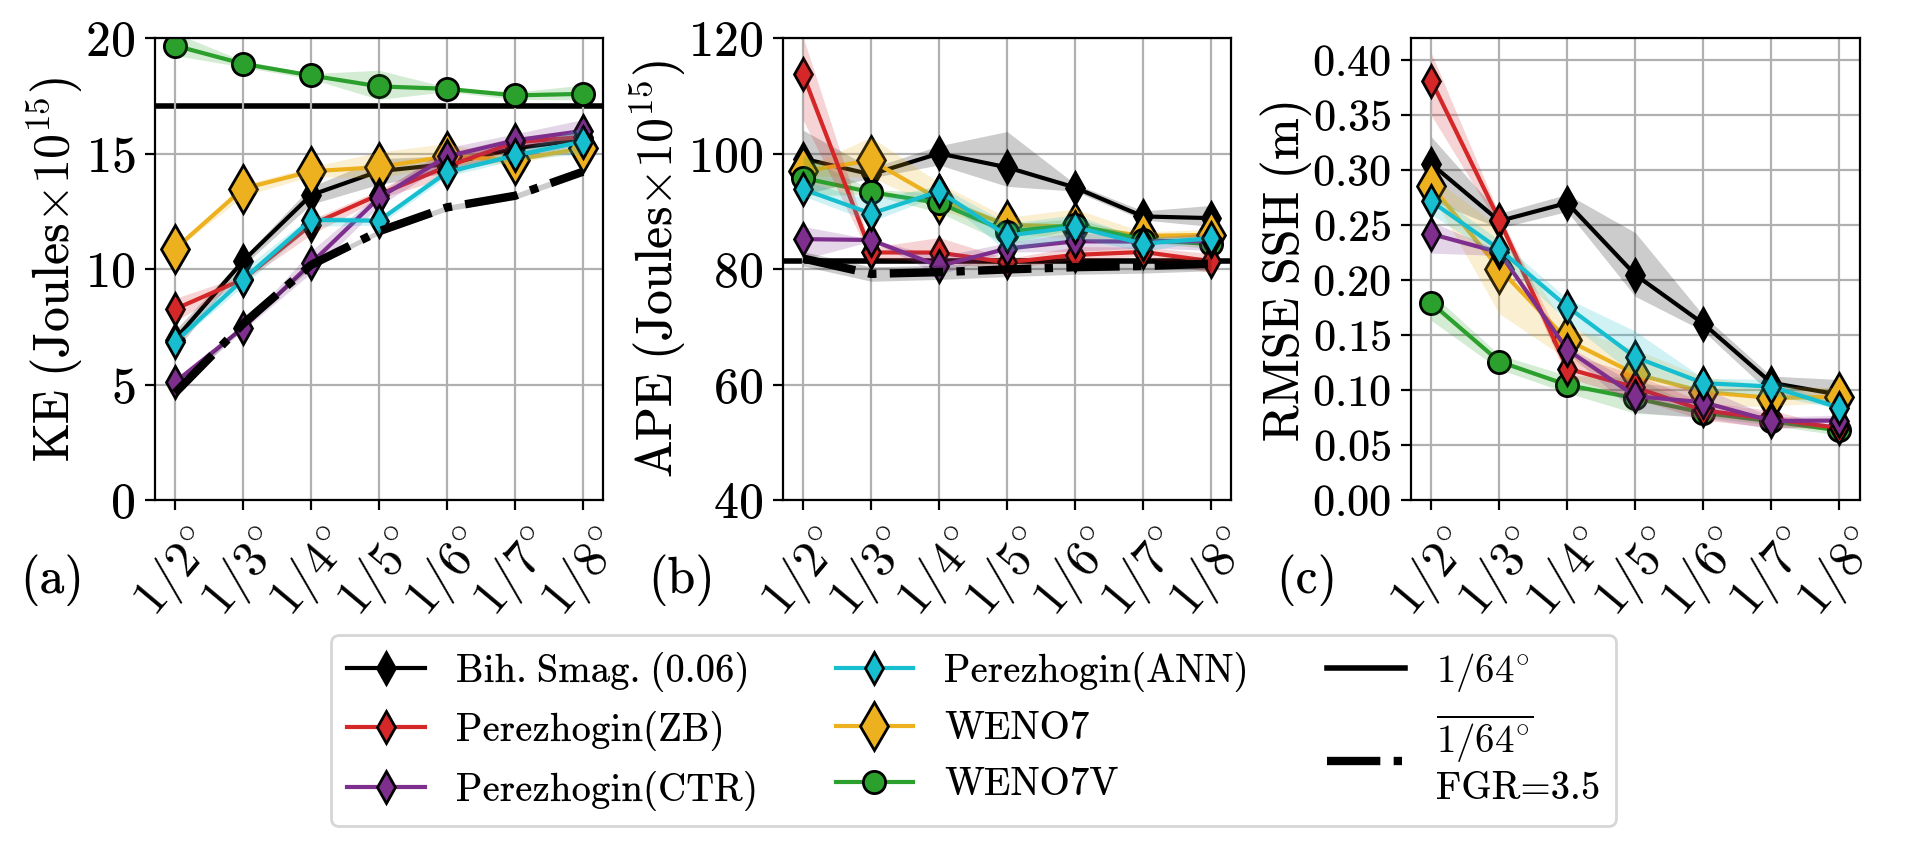

In [89]:
default_rcParams({'font.size': 18, 'figure.subplot.wspace': 0.4, 'figure.subplot.hspace': 0.1})
plt.figure(figsize=(11,3), dpi=200)

yellow = [0.9290, 0.6940, 0.1250]
violet = [0.4940, 0.1840, 0.5560]
lightblue = [0.3010, 0.7450, 0.9330]

for row, fun_str in enumerate(['KE', 'APE', 'ssh']):
    plt.subplot(1,3,row+1)

    def plot_markers_with_filling(model='Jansen-Held', color='tab:red', marker='s', label=None, markersize=None, lw=None, ls=None, alpha=1, zorder=None):
        try:
            ave = []
            if 'sample' in error[model].dims:
                ave.append('sample')
            if 'zl' in error[model].dims:
                ave.append('zl')
    
            error[model].mean(ave).plot(color=color, marker=marker, label=label, markersize=markersize, markeredgecolor='k', lw=lw, ls=ls, alpha=alpha, zorder=zorder)
            plt.fill_between(range(7), error[model].min(ave), error[model].max(ave), color=color, alpha=0.2, lw=0, zorder=zorder)
        except:
            pass
    
    
    plot_markers_with_filling(f'bare-{fun_str}', 'k', 'd', 'Bih. Smag. (0.06)', 8, zorder=2)
    #plot_markers_with_filling(f'bare-0.03-{fun_str}', 'tab:gray', 'd', 'Bih. Smag. (0.03)', 8, zorder=2)
    #plot_markers_with_filling(f'bare-0.01-{fun_str}', 'tab:gray', 'd', 'Bih. Smag. (0.01)', 8, zorder=2)
    #plot_markers_with_filling(f'Jansen-Held-{fun_str}', 'tab:red', 'd', 'JHAH15', 8, alpha=1, zorder=2)

    plot_markers_with_filling(f'ZB-Smooth-{fun_str}', 'tab:red', 'd', 'Perezhogin(ZB)', 8, alpha=1,zorder=3)
    plot_markers_with_filling(f'DbMM-R-{fun_str}', violet, 'd', 'Perezhogin(CTR)', 8, alpha=1,zorder=3)
    plot_markers_with_filling(f'ANN-{fun_str}', 'tab:cyan', 'd', 'Perezhogin(ANN)', 8, alpha=1,zorder=3)

    plot_markers_with_filling(f'WENO7-{fun_str}', yellow, 'd', 'WENO7', 12, zorder=2)
    plot_markers_with_filling(f'WENO7V-{fun_str}', 'tab:green', 'o', 'WENO7V', 8, zorder=2)
    
    #plot_markers_with_filling(f'DbMM-R-{fun_str}', 'tab:green', 'o', 'Vorticity closure', 8, alpha=1,zorder=5)
    
    #plot_markers_with_filling(f'DbMMh-R-{fun_str}', violet, 'o', 'Vorticity+thickness closure', 8, alpha=1,zorder=4)
    #plot_markers_with_filling(f'GM-125-{fun_str}', 'tab:orange', 'd', 'Bih. Smag+\nGent-McWilliams', 8, alpha=1, zorder=2)
    
    if fun_str in ['KE', 'APE']:
       plot_markers_with_filling(f'R64-FGR-sqrt12-{fun_str}', 'k', '', 'filtered \n$1/64^{\circ}$', ls='-.', lw=3,zorder=6)
    
    plt.xticks([0,1,2,3,4,5,6], ['$1/2^{\circ}$', '$1/3^{\circ}$', '$1/4^{\circ}$', '$1/5^{\circ}$', '$1/6^{\circ}$', '$1/7^{\circ}$', '$1/8^{\circ}$'],rotation=50)    
    plt.grid()
    plt.xlabel('')
    if fun_str == 'KE':
        yticks = np.arange(0,40,5)
        plt.ylabel('KE (Joules$\\times10^{15}$)')
        plt.yticks(yticks)
        plt.ylim([0,20])
        plt.axhline(y=17.04075970194989,color='k', zorder=-1,lw=2)
        #plt.title('Kinetic energy (KE)', fontsize=16)
        #plt.text(0.0, 17.5,'$1/64^{\circ}$', color='gray')
    if fun_str == 'EKE':
        yticks = np.arange(0,40,5)
        plt.ylabel('EKE, Joules$\\times10^{15}$')
        plt.axhline(y=10.91081797,color='gray', zorder=-1,lw=3)
        plt.yticks(yticks)
        plt.ylim([0,20])
    if fun_str == 'MKE':
        yticks = np.arange(0,40,5)
        plt.ylabel('MKE, Joules$\\times10^{15}$')
        plt.axhline(y=6.12994173,color='gray', zorder=-1,lw=3)
        plt.yticks(yticks)
        plt.ylim([0,20])
    if fun_str == 'APE':
        yticks = np.arange(40,130,20)
        plt.ylabel('APE (Joules$\\times10^{15}$)')
        #plt.title('Available \n potential energy (APE)', fontsize=16)
        plt.yticks(yticks)
        plt.ylim([min(yticks), max(yticks)])
        plt.axhline(y=81.31324435644875,color='k',zorder=-1,lw=2)
    
    if fun_str == 'ssh':
        yticks = np.arange(0,0.45,0.05)
        plt.ylabel('RMSE SSH (m)')
        #plt.title('RMSE in time-averaged \nsea surface height (SSH)', fontsize=16)
        plt.yticks(yticks, fontsize=16)
        plt.ylim([0,0.42])

    if fun_str == 'Cs':
        plt.ylim([0,0.1])
        plt.ylabel('$C_S$')

plt.gcf().align_ylabels()
#set_letters(fontsize=18,x=0.0,y=1.05)
plt.plot(np.nan,np.nan,'-',color='k',lw=2,label='$1/64^{\circ}$')
plt.plot(np.nan,np.nan,'-.',color='k',lw=3,label='$\\overline{1/64^{\circ}}$\nFGR=3.5')
#plt.plot(np.nan,np.nan,'--',color='k',lw=3,label='filtered $1/64^{\circ}$')
plt.legend(ncol=3, bbox_to_anchor=(0.5,-0.25), fontsize=14)

set_letters(fontsize=18, x=-0.3,y=-0.2, fontweight='normal')
#plt.tight_layout()

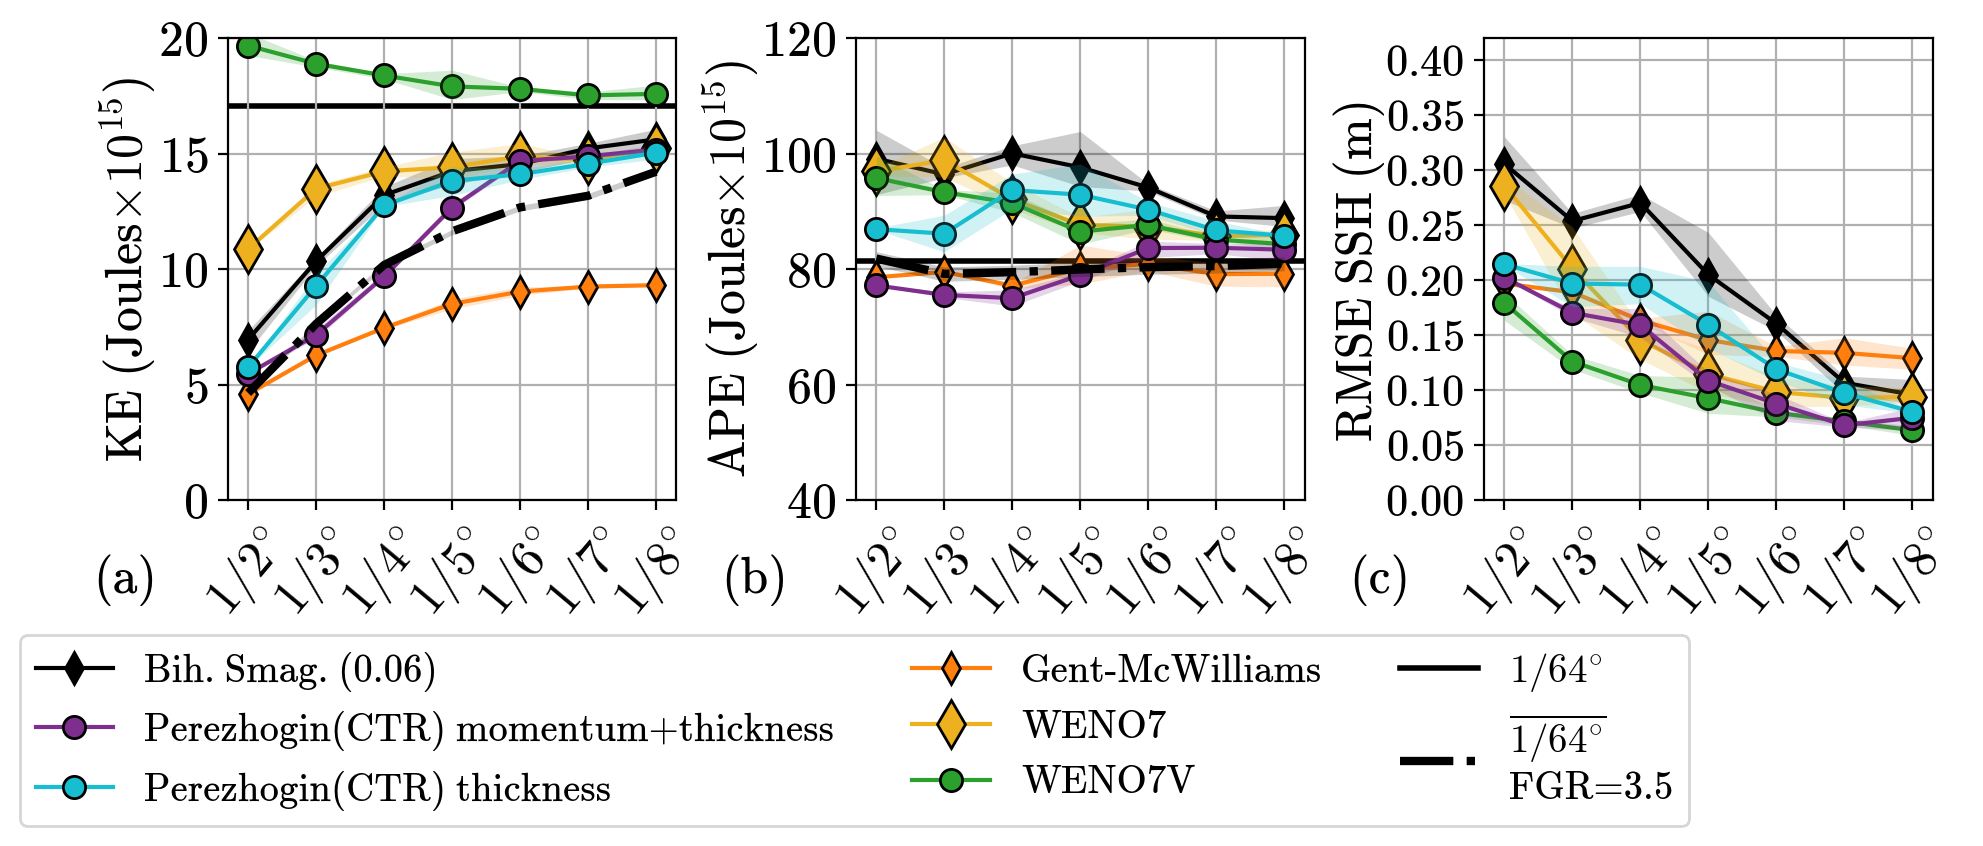

In [94]:
default_rcParams({'font.size': 18, 'figure.subplot.wspace': 0.4, 'figure.subplot.hspace': 0.1})
plt.figure(figsize=(11,3), dpi=200)

yellow = [0.9290, 0.6940, 0.1250]
violet = [0.4940, 0.1840, 0.5560]
lightblue = [0.3010, 0.7450, 0.9330]

for row, fun_str in enumerate(['KE', 'APE', 'ssh']):
    plt.subplot(1,3,row+1)

    def plot_markers_with_filling(model='Jansen-Held', color='tab:red', marker='s', label=None, markersize=None, lw=None, ls=None, alpha=1, zorder=None):
        try:
            ave = []
            if 'sample' in error[model].dims:
                ave.append('sample')
            if 'zl' in error[model].dims:
                ave.append('zl')
    
            error[model].mean(ave).plot(color=color, marker=marker, label=label, markersize=markersize, markeredgecolor='k', lw=lw, ls=ls, alpha=alpha, zorder=zorder)
            plt.fill_between(range(7), error[model].min(ave), error[model].max(ave), color=color, alpha=0.2, lw=0, zorder=zorder)
        except:
            pass
    
    
    plot_markers_with_filling(f'bare-{fun_str}', 'k', 'd', 'Bih. Smag. (0.06)', 8, zorder=2)
    #plot_markers_with_filling(f'bare-0.03-{fun_str}', 'tab:gray', 'd', 'Bih. Smag. (0.03)', 8, zorder=2)
    #plot_markers_with_filling(f'bare-0.01-{fun_str}', 'tab:gray', 'd', 'Bih. Smag. (0.01)', 8, zorder=2)
    #plot_markers_with_filling(f'Jansen-Held-{fun_str}', 'tab:red', 'd', 'JHAH15', 8, alpha=1, zorder=2)

    #plot_markers_with_filling(f'ZB-Smooth-{fun_str}', 'tab:red', 'd', 'Perezhogin(ZB)', 8, alpha=1,zorder=3)
    #plot_markers_with_filling(f'DbMM-R-{fun_str}', violet, 'd', 'Perezhogin(CTR)', 8, alpha=1,zorder=3)
    #plot_markers_with_filling(f'ANN-{fun_str}', 'tab:cyan', 'd', 'Perezhogin(ANN)', 8, alpha=1,zorder=3)

    plot_markers_with_filling(f'DbMMh-R-{fun_str}', violet, 'o', 'Perezhogin(CTR) momentum+thickness', 8, alpha=1,zorder=4)
    plot_markers_with_filling(f'Smagh-{fun_str}', 'tab:cyan', 'o', 'Perezhogin(CTR) thickness', 8, alpha=1,zorder=4)
    plot_markers_with_filling(f'GM-125-{fun_str}', 'tab:orange', 'd', 'Gent-McWilliams', 8, alpha=1, zorder=2)
    

    plot_markers_with_filling(f'WENO7-{fun_str}', yellow, 'd', 'WENO7', 12, zorder=2)
    plot_markers_with_filling(f'WENO7V-{fun_str}', 'tab:green', 'o', 'WENO7V', 8, zorder=2)
    
    #plot_markers_with_filling(f'DbMM-R-{fun_str}', 'tab:green', 'o', 'Vorticity closure', 8, alpha=1,zorder=5)
    
    if fun_str in ['KE', 'APE']:
       plot_markers_with_filling(f'R64-FGR-sqrt12-{fun_str}', 'k', '', 'filtered \n$1/64^{\circ}$', ls='-.', lw=3,zorder=6)
    
    plt.xticks([0,1,2,3,4,5,6], ['$1/2^{\circ}$', '$1/3^{\circ}$', '$1/4^{\circ}$', '$1/5^{\circ}$', '$1/6^{\circ}$', '$1/7^{\circ}$', '$1/8^{\circ}$'],rotation=50)    
    plt.grid()
    plt.xlabel('')
    if fun_str == 'KE':
        yticks = np.arange(0,40,5)
        plt.ylabel('KE (Joules$\\times10^{15}$)')
        plt.yticks(yticks)
        plt.ylim([0,20])
        plt.axhline(y=17.04075970194989,color='k', zorder=-1,lw=2)
        #plt.title('Kinetic energy (KE)', fontsize=16)
        #plt.text(0.0, 17.5,'$1/64^{\circ}$', color='gray')
    if fun_str == 'EKE':
        yticks = np.arange(0,40,5)
        plt.ylabel('EKE, Joules$\\times10^{15}$')
        plt.axhline(y=10.91081797,color='gray', zorder=-1,lw=3)
        plt.yticks(yticks)
        plt.ylim([0,20])
    if fun_str == 'MKE':
        yticks = np.arange(0,40,5)
        plt.ylabel('MKE, Joules$\\times10^{15}$')
        plt.axhline(y=6.12994173,color='gray', zorder=-1,lw=3)
        plt.yticks(yticks)
        plt.ylim([0,20])
    if fun_str == 'APE':
        yticks = np.arange(40,130,20)
        plt.ylabel('APE (Joules$\\times10^{15}$)')
        #plt.title('Available \n potential energy (APE)', fontsize=16)
        plt.yticks(yticks)
        plt.ylim([min(yticks), max(yticks)])
        plt.axhline(y=81.31324435644875,color='k',zorder=-1,lw=2)
    
    if fun_str == 'ssh':
        yticks = np.arange(0,0.45,0.05)
        plt.ylabel('RMSE SSH (m)')
        #plt.title('RMSE in time-averaged \nsea surface height (SSH)', fontsize=16)
        plt.yticks(yticks, fontsize=16)
        plt.ylim([0,0.42])

    if fun_str == 'Cs':
        plt.ylim([0,0.1])
        plt.ylabel('$C_S$')

plt.gcf().align_ylabels()
#set_letters(fontsize=18,x=0.0,y=1.05)
plt.plot(np.nan,np.nan,'-',color='k',lw=2,label='$1/64^{\circ}$')
plt.plot(np.nan,np.nan,'-.',color='k',lw=3,label='$\\overline{1/64^{\circ}}$\nFGR=3.5')
#plt.plot(np.nan,np.nan,'--',color='k',lw=3,label='filtered $1/64^{\circ}$')
plt.legend(ncol=3, bbox_to_anchor=(0.5,-0.25), fontsize=14)

set_letters(fontsize=18, x=-0.3,y=-0.2, fontweight='normal')
#plt.tight_layout()